<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.891 · Aprendizaje automático · PEC2</p>
<p style="margin: 0; text-align:right;">2024-1 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# PEC 2: Aprendizaje no supervisado

En esta práctica, exploraremos el uso de modelos de lenguaje grandes (LLMs) para la generación de embeddings, aplicaremos técnicas de reducción de dimensionalidad y utilizaremos varios algoritmos de clustering para analizar el feedback de clientes sobre la empresa UPS obtenido de Yelp. Al finalizar, realizaremos un análisis detallado de los resultados obtenidos.

**Importante:** cada uno de los ejercicios puede suponer varios minutos de ejecución, por lo que la entrega debe hacerse en formato notebook y en formato html, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a html desde el menú File $\to$ Download as $\to$ HTML.

**Importante:** existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de cada PEC. Para cambiar el tipo de celda a este tipo, elegid en el menú: Cell $\to$ Cell Type $\to$ Markdown.

**Importante:** no olvidéis poner vuestro nombre y apellidos en la siguiente celda.

<div class="alert alert-block alert-info">
<strong>Nombre y apellidos:</strong>
</div>

In [1]:
# Víctor M Sola Rodríguez

Para la realización de la práctica necesitaremos importar los siguientes módulos:

In [2]:
import json
from typing import List

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sentence_transformers import SentenceTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import datasets
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, HDBSCAN, MeanShift, estimate_bandwidth
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tqdm
import umap

!pip install pandas
import pandas as pd
from sklearn.preprocessing import StandardScaler

seed = 42

## Carga del conjunto de datos y preprocesado (1.5 puntos)

Se utilizará un dataset de comentarios de clientes sobre la empresa UPS recopilados de [Yelp](https://www.yelp.com/dataset), contenido en el archivo reviews_ups.txt, donde cada línea es una review. Recuerden que puede haber reviews sin contenido, las cuales deberán ser limpiadas durante el preprocesamiento.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> carga las opiniones del archivo en una lista y elimina aquellas opiniones que estén literalmente vacías.
</div>

Como el archivo no tiene una estructura json correcta en su conjunto, leemos las líneas usando readlines (cada línea será un json) y luego convertimos cada línea a un diccionario para acceder fácilmente al contenido.

In [3]:
# Cargamos archivo JSON
with open('reviews_stars_ups.json','r', encoding = 'utf-8') as file:
    data_lines = file.readlines()

# Convertimos a diccionarios
data_dict = [json.loads(lna.strip()) for lna in data_lines]
# data_json[0]
# data_json[0].keys()


In [4]:
# Comprobamos posibles reviews sin contenido
if any(value == "" or value is None for review in data_dict for value in review.values()):
    print("Hay valores vacíos.")
else:
    print("No hay valores vacíos.")

No hay valores vacíos.


In [5]:
# Seleccionamos solamente el contenido de texto de cada review 
# para luego hacer el embedding
review_textos = [review["text"] 
                 for review in data_dict 
                 if "text" in review and review["text"] not in (None,"")]

# Seleccionamos también por separado las puntuaciones.
# El orden de los elementos de review_textos y review_stars se mantiene. 
review_stars = [review["stars"] 
                 for review in data_dict 
                 if "stars" in review and review["stars"] not in (None,"")]
# review_textos[0]
# review_stars[0]

Hoy en día, el análisis de texto en lenguaje natural ha sido revolucionado por los Modelos de Lenguaje Grandes (LLMs), los cuales han reemplazado las técnicas clásicas como TF-IDF y Bag of Words para la representación de texto. Estas técnicas clásicas, aunque útiles, eran limitadas al crear representaciones dispersas y poco contextuales de los textos. En cambio, los LLMs permiten generar representaciones densas o embeddings, que capturan de manera mucho más efectiva el significado semántico de las palabras y las relaciones entre ellas.

Para comprender como funcionan los modelos de lenguaje se recomienda el siguiente video que, en el minuto 12, explica visualmente la parte de embeddings (representación vectorial de palabras o frases) que usaremos en la PEC: https://www.youtube.com/watch?v=wjZofJX0v4M

En esta práctica, vamos a crear una representación densa (embedding) de las reviews utilizando MiniLM, un modelo ligero que ofrece una excelente capacidad para generar embeddings de texto manteniendo un balance entre rendimiento y eficiencia computacional. MiniLM está basado en la arquitectura Transformer, similar a otros modelos más grandes como BERT, pero optimizado para ser más pequeño y rápido, lo que lo hace ideal para tareas como la nuestra. En concreto, utilizaremos la versión "all-MiniLM-L6-v2", que puedes descargar comprimida en un fichero zip desde el siguiente enlace: https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/v0.2/all-MiniLM-L6-v2.zip

Una vez descargado el archivo, debes descomprimirlo y colocar el directorio extraído en el mismo directorio donde se encuentra este notebook, para facilitar su carga.

Para cargar el modelo, utilizaremos la biblioteca sentence-transformers, la cual es una herramienta que facilita el uso de modelos preentrenados para la generación de embeddings de texto. Esta biblioteca está construida sobre modelos como BERT, MiniLM, y otros, y nos permite, con unas pocas líneas de código, transformar frases y textos en representaciones vectoriales de alta calidad. Aquí puedes encontrar más documentación sobre sentence-transformers y el modelo en concreto de MiniLM: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

Al tener el modelo descargado en local sólo es necesario indicar el nombre del directorio descomprimido donde se encuentra el modelo (que coincide con el nombre del modelo).

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> carga el modelo de MiniLM y crea el embedding para la frase "Estoy resolviendo la PEC 2"
</div>

In [6]:
pip install -U sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [7]:
from sentence_transformers import SentenceTransformer

# Cargamos modelo
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Creamos embedding
sentence_test = ["Estoy resolviendo la PEC 2 "]
embedding_test = model.encode(sentence_test)

# print(embedding_test)

Para crear los embeddings de cada una de las frases del dataset, debemos tener en cuenta que este proceso puede ser algo más lento que algunas otras operaciones, ya que implica transformar cada frase en una representación densa a través de un modelo de lenguaje. Dependiendo del tamaño del dataset y de la capacidad de la máquina, el tiempo requerido podría ser de unos 5 minutos en una máquina estándar. Sin embargo, podemos aplicar ciertas optimizaciones para acelerar este proceso.

Una manera eficiente de hacerlo es procesar las frases en lotes (batches) en lugar de procesarlas una por una. La biblioteca sentence-transformers nos permite pasar directamente la lista completa de frases y dividirlas en lotes más pequeños, haciendo que el cálculo de los embeddings sea más rápido al aprovechar la capacidad de paralelización de la máquina. Para esto, podemos utilizar el parámetro batch_size en el método `encode()`. Por ejemplo, si configuramos `batch_size=256`, indicaremos al modelo que procese 256 reviews al mismo tiempo, lo cual acelera el procesamiento considerablemente. Si el proceso es muy lento, puedes reducir este número para que se adapte a las características de tu máquina.

Además, para poder realizar un seguimiento del progreso del cálculo, podemos habilitar una barra de progreso con el parámetro `show_progress_bar=True`. Esto nos permitirá tener una visión clara de cuánto falta para completar el procesamiento, lo cual es especialmente útil cuando trabajamos con datasets grandes.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> calcula el embedding de todas las reviews (no vacías)
</div>

In [8]:
# Creamos embedding para las frases del documento de reviews
embeddings = model.encode(review_textos, batch_size=256, show_progress_bar=True)

Batches:   0%|          | 0/18 [00:00<?, ?it/s]

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Cuántas dimensiones tiene el embedding generado por MiniLM?
</div>

In [9]:
# Mostramos dimensiones del embedding
print("Dimensión: {}".format(embeddings.shape))

Dimensión: (4485, 384)


## Reducción de dimensionalidad (2.5 puntos)

El embedding generado por el modelo tiene una alta dimensionalidad. Aunque esta representación es ideal para capturar relaciones semánticas complejas entre frases, es difícil de interpretar y visualizar directamente debido a la alta cantidad de dimensiones.

Para poder visualizar los embeddings y entender mejor cómo se agrupan las reviews similares, necesitamos reducir la dimensionalidad del espacio a algo más manejable, como 2 dimensiones. Al hacerlo, podemos representar gráficamente las frases en un plano, lo que nos permitirá identificar patrones, clusters de frases similares y relaciones entre diferentes opiniones.

En cuanto a la visualización, dado que tenemos miles de puntos (uno por cada embedding generado), es importante asegurarnos de que el gráfico no se vuelva confuso o demasiado saturado. Para ello, utilizaremos un `scatter` plot de Matplotlib y aprovecharemos el parámetro `alpha=0.1`, el cual ajusta la transparencia de los puntos en el gráfico. Esto nos permitirá visualizar claramente las áreas más densas, ya que donde haya una mayor concentración de puntos, estos se superpondrán y se verán más oscuros, facilitando la identificación de zonas con alta densidad de opiniones similares.

### PCA (Principal Component Analysis)
PCA encuentra las direcciones de mayor varianza en los datos y proyecta los puntos hacia esas direcciones. Es rápida y eficiente, pero cuidado porque en algunos casos puede no capturar bien las relaciones no lineales presentes en los embeddings.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> reduce a 2 dimensiones cada una de las reviews y visualiza el resultado donde el color de cada punto se corresponda con las estrellas de esa review. Añade una leyenda para poder interpretar los colores.
</div>

In [10]:
# 1º estandarizamos
scaler = StandardScaler()
embeddings_std = scaler.fit_transform(embeddings)

# 2º Aplicamos PCA
pca = PCA(n_components=2)
embeddings_std_pca = pca.fit_transform(embeddings_std)

Text(0.5, 1.0, 'PCA')

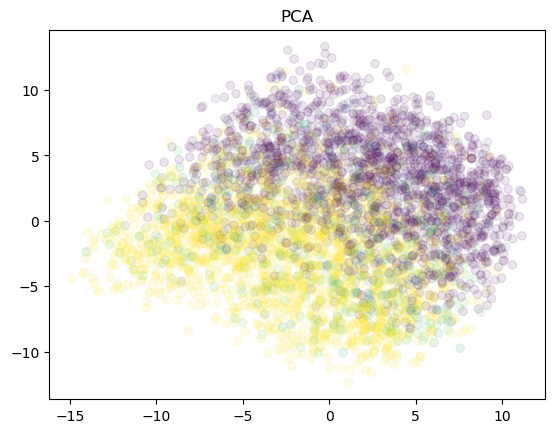

In [11]:
# 3º Visualizamos resultado
plt.scatter(embeddings_std_pca[:,0], embeddings_std_pca[:,1], c = review_stars, alpha = 0.1)
plt.title("PCA")

### t-SNE (t-distributed Stochastic Neighbor Embedding)
t-SNE es una técnica para reducir la dimensionalidad preservando las relaciones locales (es decir, mantiene los puntos similares cerca unos de otros). Aunque es más lento que PCA, t-SNE no proyecta linealmente.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> reduce a 2 dimensiones cada una de las reviews y visualiza el resultado donde el color de cada punto se corresponda con las estrellas de esa review. Añade una leyenda para poder interpretar los colores.
</div>

Text(0.5, 1.0, 'T-SNE')

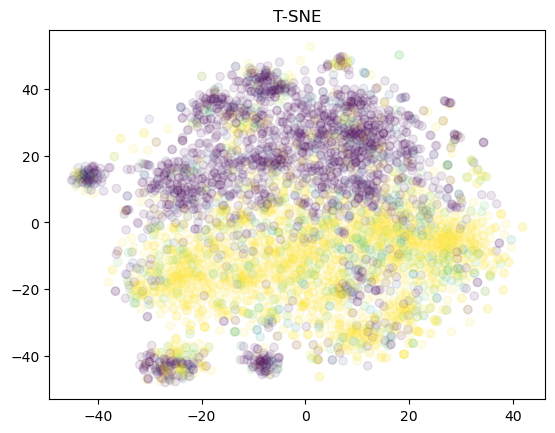

In [12]:
# Aplicamos T-SNE
tsne = TSNE(n_components=2, perplexity=50, learning_rate=500, random_state=36)
embeddings_std_tsne = tsne.fit_transform(embeddings_std)

# Visualizamos resultado
plt.scatter(embeddings_std_tsne[:,0], embeddings_std_tsne[:,1], c = review_stars, alpha = 0.1)
plt.title("T-SNE")

### UMAP (Uniform Manifold Approximation and Projection)
UMAP es una alternativa relativamente nueva que, al igual que t-SNE, trata de mantener las relaciones locales, pero suele ser más rápido y permite una mayor flexibilidad para ajustar la precisión de los resultados.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> reduce a 2 dimensiones cada una de las reviews y visualiza el resultado donde el color de cada punto se corresponda con las estrellas de esa review. Añade una leyenda para poder interpretar los colores.
</div>

Text(0.5, 1.0, 'UMAP en 2D')

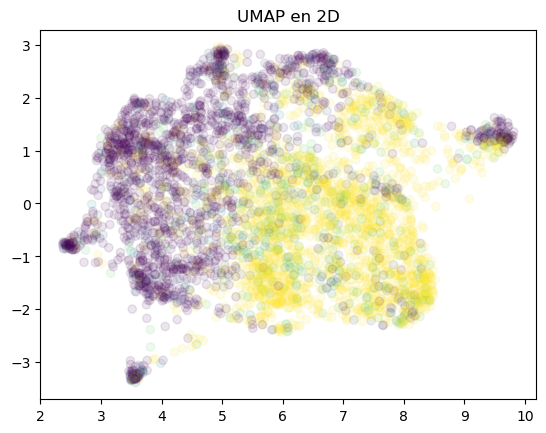

In [13]:
# Aplicamos UMAP
# Probamos varios valores de n_neighbors y min_dist y finalmente
# elegimos n_neighbors=100 y min_dist=0.1
umap_emb = umap.UMAP(n_neighbors=100,min_dist=0.1,n_components=2)
embeddings_std_umap = umap_emb.fit_transform(embeddings_std)

# Visualizamos resultado
plt.scatter(embeddings_std_umap[:,0], embeddings_std_umap[:,1], c = review_stars, alpha = 0.1)
plt.title("UMAP en 2D")

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué has observado tras su aplicación? Pese a no haber usado la información de las estrellas al realizar los embeddings ¿parece existir una relación entre la disposición de los embeddings y el número de estrellas?
</div>

Si, parece haber relación ya que hay una clara separación de colores entre las puntuaciones más bajas y más altas.
Esto indica que el texto de las reseñas va acorde a su puntuación y tienen similitudes entre ellas.
Por ejemplo, todas las reseñas positivas dirán cosas similares o en el mismo tono.

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Si tuvieses que reducir la dimensionalidad para aplicar posteriormente un modelo de aprendizaje supervisado que se entrenará una vez y en producción hará predicciones diarias. ¿Qué ventajas y desventajas tendría cada uno de los métodos? ¿por qué?
</div>

PCA lo descartaría porque solamente nos muestra diferencia clara entre las puntuaciones más alta y más bajas pero por lo demás no muestra agrupaciones. Es decir, mantiene de forma suficiente la estructura global. Además, es el método más rápido.

UMAP y T-SNE además de la diferencia entre las puntuaciones más altas y bajas, si que muestran de forma más clara algunas agrupaciones. Al ser reducciones no lineales representan mejor la información contenida en el texto de las reseñas. Es decir, además de la estructura global, conserva mucho mejor las estructuras locales. Aunque ambos son más lentos que PCA.

Por otro lado, T-SNE es un poco lento que UMAP.
Por lo que la elección recomendada sería UMAP.

### Validación en 3 dimensiones

Después de visualizar la reducción a dos dimensiones, elige el método de reducción de dimensionalidad que consideres más adecuado.
Luego, valida que las estructuras identificadas se mantienen al extender la visualización a tres dimensiones. Esta validación permite agregar más información y verificar si los patrones observados persisten cuando se incorpora una dimensión adicional, lo cual proporciona una visión más completa de la organización de los datos.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> crea un nuevo embedding proyectando a 3 dimensiones con el método elegido y visualiza con matplotlib manteniendo el color como indicativo del número de estrellas de cada review.
</div>

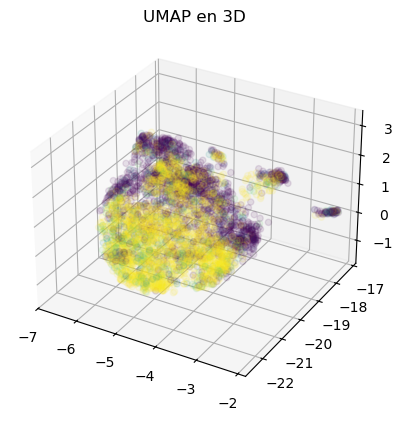

In [14]:
# Aplicamos UMAP en 3D
umap_emb = umap.UMAP(n_neighbors=100,min_dist=0.1,n_components=3)
embeddings_std_umap3D = umap_emb.fit_transform(embeddings_std)

# Visualizamos resultado
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(embeddings_std_umap3D[:,0], embeddings_std_umap3D[:,1], embeddings_std_umap3D[:,2], c = review_stars, alpha = 0.1)
ax.set_title("UMAP en 3D")

plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Es coherente esta visualización con lo observado en la figura 2d?
</div>

Si, coinciden. Se ve la misma separación de colores y se pueden identificar algunos clusters vistos en la representación 2D.

### Dendrograma

Además de la visualización de los datos en 2 dimensiones mediante métodos de reducción de dimensionalidad, podemos también tratar de entender cómo se distribuyen los puntos en el espacio de alta dimensionalidad utilizando una técnica diferente: el **dendrograma**.

Un dendrograma es una **representación gráfica que muestra la estructura jerárquica de un conjunto de datos**. Este tipo de gráfico es especialmente útil para entender las relaciones entre puntos de datos cuando queremos agruparlos de manera jerárquica. El dendrograma se genera como parte del algoritmo de clustering jerárquico, el cual intenta agrupar los datos de manera recursiva, creando una estructura en forma de árbol donde cada hoja representa un punto del dataset y cada bifurcación representa la unión de dos grupos.

Cómo interpretar un dendrograma:

En la parte inferior del dendrograma, cada hoja representa un dato individual (en este caso, una review).
- A medida que nos movemos hacia arriba, los puntos que están más cercanos entre sí se van agrupando, y esos grupos se unen en niveles superiores hasta que, eventualmente, todos los puntos se juntan en un único grupo en la parte superior.
- Las distancias verticales indican la similitud o disimilitud entre los grupos que se están uniendo. Cuanto mayor es la altura a la que se unen dos grupos, mayor es la disimilitud entre ellos. Por lo tanto, un dendrograma nos da una idea visual de qué puntos están más cerca unos de otros y cómo los clusters más pequeños se fusionan para formar clusters más grandes.
- Utilizando un dendrograma, podemos decidir cuántos clusters tiene sentido crear, observando dónde sería adecuado cortar el árbol. Por ejemplo, si encontramos un punto donde los grupos se empiezan a unir con una gran distancia, podría indicar que ese es un buen lugar para cortar y definir el número de clusters.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> visualiza el dendrograma teniendo en cuenta estos parámetros:
<ul>
<li><strong>truncate_mode='level'</strong>: limita la profundidad del dendrograma, mostrando solo un número determinado de niveles de unión, lo cual es útil para evitar un gráfico excesivamente complejo.

<li><strong>p=200</strong>: cuántos clusters o niveles se mostrarán. En este caso, se visualizarán hasta 500 grupos, permitiendo un buen equilibrio entre detalle y simplicidad.

<li><strong>no_labels=True</strong>: oculta las etiquetas de cada punto para evitar que el gráfico se vea sobrecargado y se genere más rápido.

<li><strong>method='single'</strong>: es una manera intuitiva de agrupar las muestras, pues define la distancia entre dos grupos como la distancia entre los puntos más cercanos en cada grupo.
</ul>
</div>

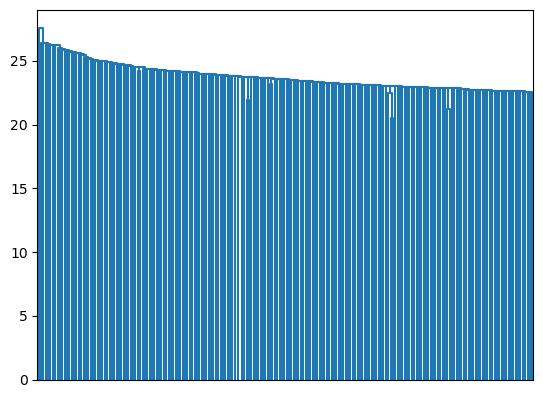

In [15]:
emb_linked = linkage(embeddings_std, method='single')
dendrogram(emb_linked, p=200, truncate_mode='level', no_labels=True)
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué podemos observar en el dendrograma? ¿Algo similar a los observado en las reducciones de dimensionalidad?
</div>

A la vista del resultado obtenido, podemos ver un poco antes de llegar a la mitad del eje x una línea blanca que "separa" el gráfico en 2 grandes grupos. Esto recuerda a la separación que hemos visto en 2 colores principales en las anteriores representaciones.
Esta separación nos indica un buen punto de corte, que sería en y=24. Y probablemente refleje 2 grupos de reseñas, siendo similares dentro del grupo y bastante diferentes a las del otro grupo.

## Clustering (3 puntos)

Tras haber visualizado el conjunto de datos y examinado el dendrograma, hemos obtenido una visión más profunda sobre la estructura y las relaciones internas del dataset. Esta información nos ayudará a tomar una decisión informada sobre cuál es la mejor estrategia de clustering a seguir. Sin embargo, antes de definir nuestra estrategia final, es importante explorar cómo funcionan distintos algoritmos de clustering, para comprender mejor sus ventajas y limitaciones.

En este contexto, realizaremos algunos experimentos utilizando diferentes algoritmos de clustering. Probaremos enfoques como **K-means**, **clustering jerárquico**, **DBSCAN**, y **Mean-Shift**.

Para ello contamos con los siguientes datasets:

In [16]:
n_samples = 1000
blobs_data, blobs_labels = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=seed)
moons_data, moons_labels = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
circles_data, circles_labels = datasets.make_circles(n_samples=n_samples, factor=0.4, noise=0.05, random_state=seed)

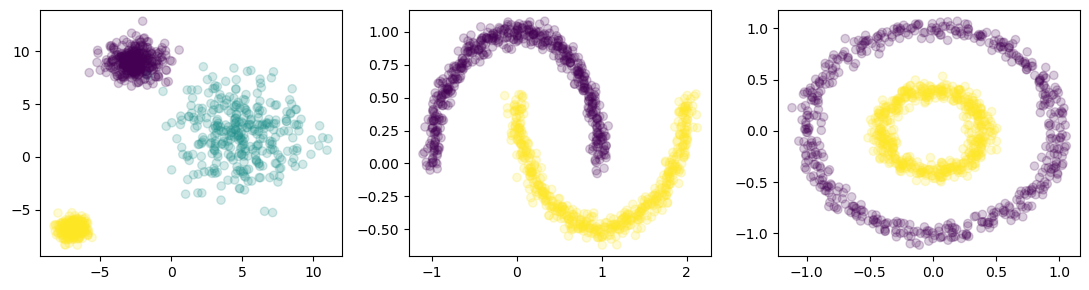

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(11, 3))
ax[0].scatter(blobs_data[:,0], blobs_data[:,1], c=blobs_labels, alpha=.2)
ax[1].scatter(moons_data[:,0], moons_data[:,1], c=moons_labels, alpha=.2)
ax[2].scatter(circles_data[:,0], circles_data[:,1], c=circles_labels, alpha=.2)
plt.tight_layout()

In [18]:
# Probamos a normalizar los datos a ver si mejoran las representaciones,
# pero no se ven mejoras.
# blobs_data = scaler.fit_transform(blobs_data)
# moons_data = scaler.fit_transform(moons_data)
# circles_data = scaler.fit_transform(circles_data)

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> aplica K-means a los tres datasets anteriores y visualiza su resultado.
</div>

C:\Users\VIK\anaconda3\envs\environment_uoc20241pec2\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\VIK\anaconda3\envs\environment_uoc20241pec2\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\VIK\anaconda3\envs\environment_uoc20241pec2\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


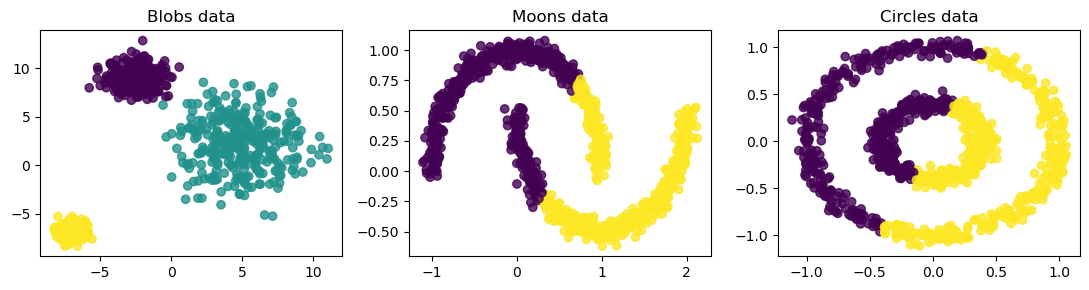

In [19]:
# APLICAMOS K-MEANS

# BLOBS DATA
# Usamos k=3 porque ya vemos directamente en el gráfico anterior que son 3 clústers. Si no, habría que calcular la k óptima.
k_means_blobs = KMeans(n_clusters = 3, random_state = 36)
blob_labels = k_means_blobs.fit_predict(blobs_data)

# MOONS DATA
# Usamos k=2 porque ya vemos directamente en el gráfico anterior que son 2 clústers.
k_means_moons = KMeans(n_clusters = 2, random_state = 36)
moons_labels = k_means_moons.fit_predict(moons_data)

# CIRCLES DATA
# Usamosk=2 porque ya vemos directamente en el gráfico anterior que son 2 clústers.
k_means_circles = KMeans(n_clusters = 2, random_state = 36)
circles_labels = k_means_circles.fit_predict(circles_data)


# Representamos
fig, ax = plt.subplots(1, 3, figsize=(11, 3))
ax[0].scatter(blobs_data[:,0], blobs_data[:,1], c=blobs_labels, alpha=.8)
ax[0].set_title('Blobs data')
ax[1].scatter(moons_data[:,0], moons_data[:,1], c=moons_labels, alpha=.8)
ax[1].set_title('Moons data')
ax[2].scatter(circles_data[:,0], circles_data[:,1], c=circles_labels, alpha=.8)
ax[2].set_title('Circles data')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> aplica clustering jerárquico a los tres datasets anteriores y visualiza su resultado.
</div>

En este caso empezamos probando linkage='ward' para los 3 casos, pero vemos que no funciona bien para moons_data ni para circles_data. Para estos dos casos, linkage='single' funciona mucho mejor.
Esto se debe a que 'single' tiene en cuenta la distancia mínima entre dos puntos, sin tener en cuenta el resto del cluster.
Por otro lado 'ward' mínimiza la varianza de los clusters.

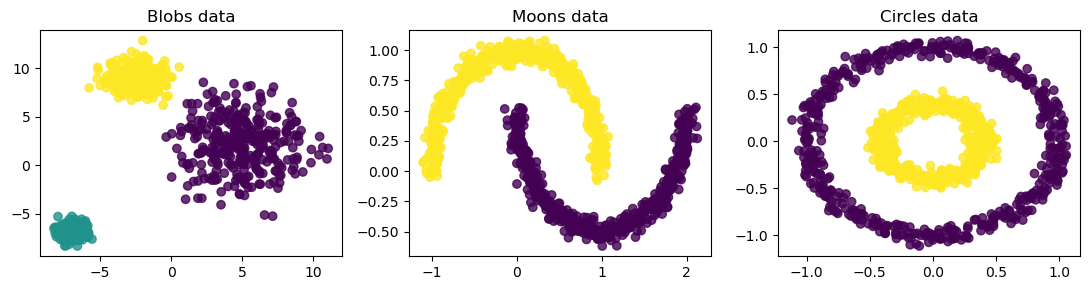

In [20]:
# APLICAMOS AGGLOMERATIVE CLUSTERING
# BLOBS DATA
agg_clus_blobs = AgglomerativeClustering(n_clusters = 3, linkage = 'ward')
agg_cluster_blobs = agg_clus_blobs.fit_predict(blobs_data)

# MOONS DATA
agg_clus_moons = AgglomerativeClustering(n_clusters = 2, linkage = 'single')
agg_cluster_moons = agg_clus_moons.fit_predict(moons_data)

# CIRCLES DATA
agg_clus_circles = AgglomerativeClustering(n_clusters = 2, linkage = 'single')
agg_cluster_circles = agg_clus_circles.fit_predict(circles_data)


# Representamos
fig, ax = plt.subplots(1, 3, figsize=(11, 3))
ax[0].scatter(blobs_data[:,0], blobs_data[:,1], c=agg_cluster_blobs, alpha=.8)
ax[0].set_title('Blobs data')
ax[1].scatter(moons_data[:,0], moons_data[:,1], c=agg_cluster_moons, alpha=.8)
ax[1].set_title('Moons data')
ax[2].scatter(circles_data[:,0], circles_data[:,1], c=agg_cluster_circles, alpha=.8)
ax[2].set_title('Circles data')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> aplica DBSCAN a los tres datasets anteriores y visualiza su resultado.
</div>

Primero tenemos que calcular eps y min_samples.
min_samples tiene que ser mayor o igual a las dimensiones de nuestros datos. Un valor adecuado es el doble de las dimensiones. En este caso min_samples = 4.

A continuación, calculamos eps.
En este caso, calculamos la distancia media entre cada punto y sus vecinos más cercanos y lo dibujamos en orden ascendente. El punto de mayor curvatura nos indicará un buen valor de eps.

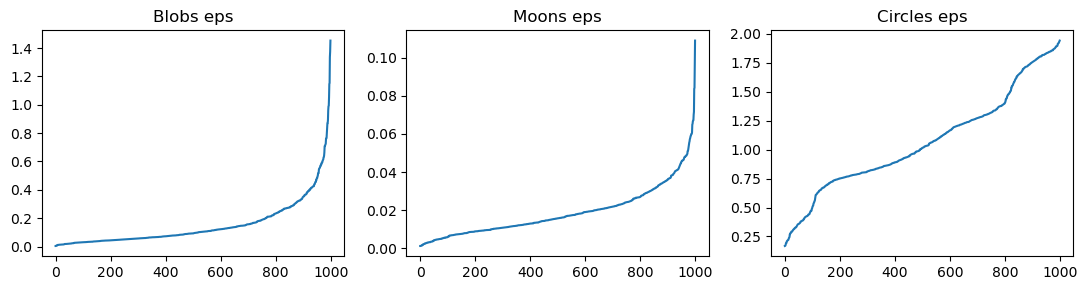

In [21]:
# Calculamos valores de eps en base a los vecinos más cercanos.
from sklearn.neighbors import NearestNeighbors
neighbors_blob = NearestNeighbors(n_neighbors=4)
neighbors_fit_blob = neighbors_blob.fit(blobs_data)
distances_blob, indices = neighbors_fit_blob.kneighbors(blobs_data)
distances_blob = np.sort(distances_blob, axis=0)
distances_blob = distances_blob[:,1]

neighbors_moons = NearestNeighbors(n_neighbors=4)
neighbors_fit_moons = neighbors_moons.fit(moons_data)
distances_moons, indices = neighbors_fit_moons.kneighbors(moons_data)
distances_moons = np.sort(distances_moons, axis=0)
distances_moons = distances_moons[:,1]

neighbors_circles = NearestNeighbors(n_neighbors=4)
neighbors_fit_circles = neighbors_circles.fit(blobs_data)
distances_circles, indices = neighbors_fit_circles.kneighbors(circles_data)
distances_circles = np.sort(distances_circles, axis=0)
distances_circles = distances_circles[:,1]

fig, ax = plt.subplots(1, 3, figsize=(11, 3))
ax[0].plot(distances_blob)
ax[0].set_title('Blobs eps')
ax[1].plot(distances_moons)
ax[1].set_title('Moons eps')
ax[2].plot(distances_circles)
ax[2].set_title('Circles eps')

plt.tight_layout()
plt.show()

Después de probar con eps igual a 0.4, 0.4 y 0.6 respectivamente, vemos que los gráficos muestran solamente 1 color predominante. Lo que indica que tal vez eps sea demasiado grande y junta todos los puntos en un mismo clúster. Al reducirlo, los gráficos de moons_data y circles_data se muestran correctamente, pero no el de blobs_data.
En el caso de blobs_data no se consigue ver bien los colores al bajar eps ni al subirlo. 

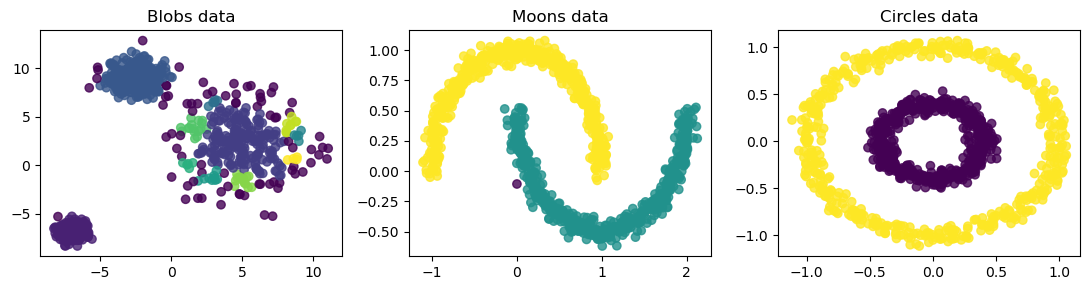

In [22]:
# APLICAMOS DBSCAN
# BLOBS DATA
dbscan_blobs = DBSCAN(eps = 0.6, min_samples = 4)
dbscan_cluster_blobs = dbscan_blobs.fit_predict(blobs_data)

# MOONS DATA
dbscan_moons = DBSCAN(eps = 0.1, min_samples = 4)
dbscan_cluster_moons = dbscan_moons.fit_predict(moons_data)

# CIRCLES DATA
dbscan_circles = DBSCAN(eps = 0.2, min_samples = 4)
dbscan_cluster_circles = dbscan_circles.fit_predict(circles_data)


# Representamos
fig, ax = plt.subplots(1, 3, figsize=(11, 3))
ax[0].scatter(blobs_data[:,0], blobs_data[:,1], c=dbscan_cluster_blobs, alpha=.8)
ax[0].set_title('Blobs data')
ax[1].scatter(moons_data[:,0], moons_data[:,1], c=dbscan_cluster_moons, alpha=.8)
ax[1].set_title('Moons data')
ax[2].scatter(circles_data[:,0], circles_data[:,1], c=dbscan_cluster_circles, alpha=.8)
ax[2].set_title('Circles data')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> aplica Mean-shift a los tres datasets anteriores y visualiza su resultado.
</div>

En este caso, para calcular el bandwidth, necesitamos decidir los valores de los parámetros quantile y n_samples.
Para quantile se suele usar 0.2 o 0.3. En función de la densidad de los datos, se usará un valor un poco más alto o un poco más bajo.
Para n_samples se suele usar un porcentaje representativo del número de muestras. En este caso usaremos el 50% de n_samples definido inicialmente.

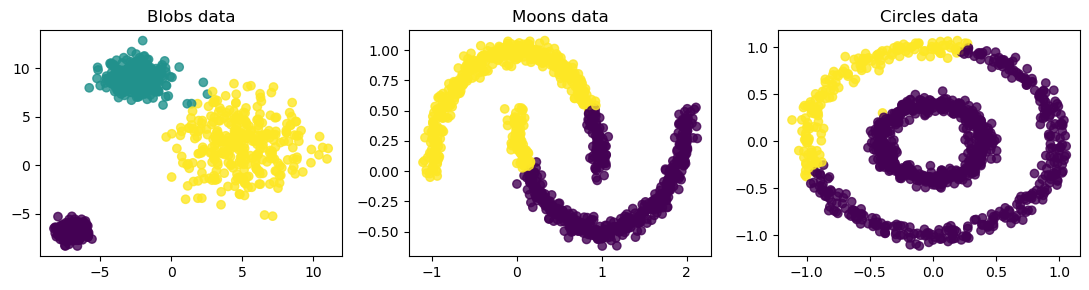

In [23]:
# APLICAMOS MEAN-SHIFT
# BLOBS DATA
bandwidth_blobs = estimate_bandwidth(blobs_data, quantile = 0.25, n_samples = 500)
ms_blobs = MeanShift(bandwidth = bandwidth_blobs)
ms_cluster_blobs = ms_blobs.fit_predict(blobs_data)

# MOONS DATA
bandwidth_moons = estimate_bandwidth(moons_data, quantile = 0.2, n_samples = 500)
ms_moons = MeanShift(bandwidth = bandwidth_moons)
ms_cluster_moons = ms_moons.fit_predict(moons_data)

# CIRCLES DATA
bandwidth_circles = estimate_bandwidth(circles_data, quantile = 0.15, n_samples = 500)
ms_circles = MeanShift(bandwidth = bandwidth_circles)
ms_cluster_circles = ms_circles.fit_predict(circles_data)


# Representamos
fig, ax = plt.subplots(1, 3, figsize=(11, 3))
ax[0].scatter(blobs_data[:,0], blobs_data[:,1], c=ms_cluster_blobs, alpha=.8)
ax[0].set_title('Blobs data')
ax[1].scatter(moons_data[:,0], moons_data[:,1], c=ms_cluster_moons, alpha=.8)
ax[1].set_title('Moons data')
ax[2].scatter(circles_data[:,0], circles_data[:,1], c=ms_cluster_circles, alpha=.8)
ax[2].set_title('Circles data')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿En qué casos no se ha podido ajustar el resultado del modelo a los clusters originales? ¿Por qué?
</div>

No se han podido ajustar:
- K-MEANS: moons_data y circles_data. Debido a que calcula la distancia entre cada punto y un centroide para asignarlo a un cluster. Esto hace que funcione bien para clusters con forma circular.

- DBSCAN: blobs_data. Es un método basado en la densidad. Grandes diferencias en las densidades de los clústeres pueden "confundir" al algoritmo.

- MEAN-SHIFT: moons_data y circles_data. Porque este algoritmo está pensado para "descubrir" clústeres circulares y trabaja en función de los centroides.

Ahora que has experimentado con varios algoritmos de clustering y comprendido sus ventajas y desventajas, es momento de tomar una decisión importante:

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué algoritmo de clustering seleccionarás para agrupar el conjunto de datos de reviews? ¿Por qué?
</div>

Descartariamos directamente K-MEANS y MEAN-SHIFT por ser buenos con formas circulares.
Seleccionariamos el algoritmo DBSCAN por trabajar en base a la densidad, característica que puede ser muy útil para los textos de las reseñas ya que pueden tener estructuras muy variadas.
Agglomerative clustering sería otra opción viable en según que circunstancias.

**Aplícalo al conjunto de datos de reviews**. Si encuentras problemas de rendimiento debido al tamaño del conjunto de datos original, puedes reducir el problema utilizando un conjunto de puntos en 3D en lugar del dato original para que el cálculo sea más rápido y eficiente.


<div class="alert alert-block alert-info">
<strong>Implementación:</strong> Aplica el algoritmo de clustering seleccionado al conjunto de datos de reviews y visualiza su resultado. Modifica los parámetros del algoritmo para que se adapte al dato.
</div>

En este caso, al tener muchas más dimensiones debemos de elegir n_neighbors bastante más elevado.

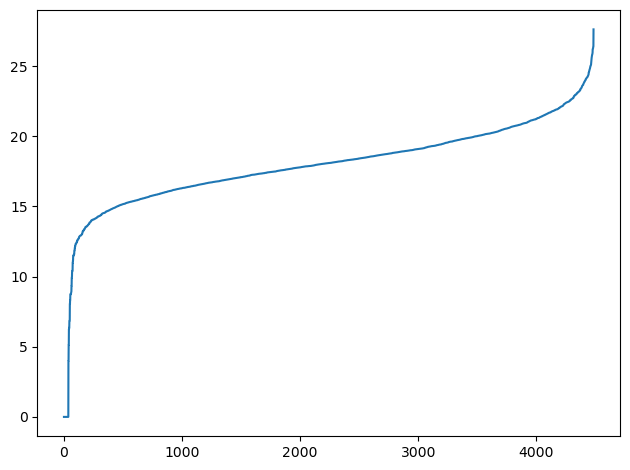

In [24]:
# Calculamos eps
neighbors_emb = NearestNeighbors(n_neighbors=20)
neighbors_fit_emb = neighbors_emb.fit(embeddings_std)
distances_emb, indices = neighbors_fit_emb.kneighbors(embeddings_std)
distances_emb = np.sort(distances_emb, axis=0)
distances_emb = distances_emb[:,1]

plt.plot(distances_emb)

plt.tight_layout()
plt.show()

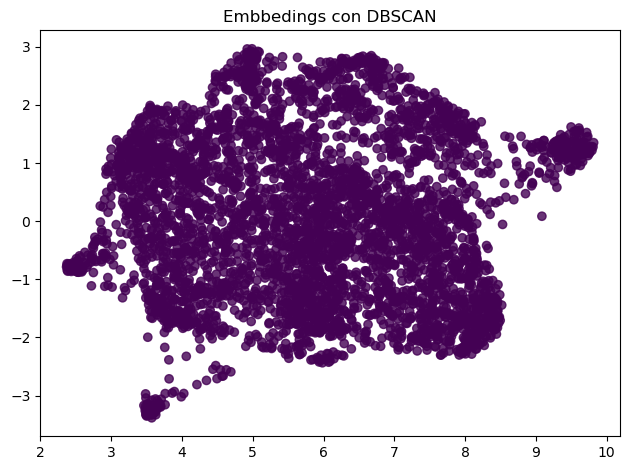

In [25]:
dbscan_emb = DBSCAN(eps = 2.3, min_samples = 20)
dbscan_cluster_emb = dbscan_emb.fit_predict(embeddings_std_umap)

# Representamos
plt.scatter(embeddings_std_umap[:,0], embeddings_std_umap[:,1], c=dbscan_cluster_emb, alpha=.8)
plt.title('Embbedings con DBSCAN')

plt.tight_layout()
plt.show()

Visto el resultado de DBSCAN se comprueba que no es la mejor elección.
Se usará Agglomerative Clustering.

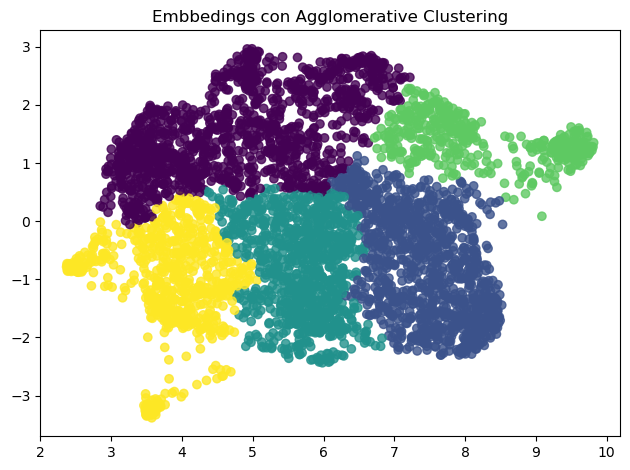

In [26]:
# Aplicamos AGGLOMERATIVE CLUSTERING

# Ponemos n_clusters = 5 para intentar formar clusters según al puntuación.
agg_clus_emb = AgglomerativeClustering(n_clusters = 5, linkage = 'ward')
agg_cluster_emb = agg_clus_emb.fit_predict(embeddings_std_umap)

# Representamos
plt.scatter(embeddings_std_umap[:,0], embeddings_std_umap[:,1], c=agg_cluster_emb, alpha=.8)
plt.title('Embbedings con Agglomerative Clustering')

plt.tight_layout()
plt.show()

## Análisis de los clusters (3 puntos)

Ahora que has realizado el clustering, es momento de analizar los resultados obtenidos para poder dar insights al negocio.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> revisa la composición de los clusters. <strong>Para cada cluster</strong> identificado, debes mostrar de manera clara y organizada la siguiente información:
<ul>
<li><strong>Número de reviews</strong> asignadas a ese cluster.
<li><strong>Media de estrellas</strong> de las reviews dentro de ese cluster.
<li><strong>Reviews representativas:</strong> selecciona 5 reviews para cada cluster que permitan tener una idea general de su contenido. Si el método de clustering utilizado calcula los centroides (es decir, el "centro" del cluster), selecciona las 5 reviews más cercanas al centroide para una representación más precisa.
Si el método no calcula centroides, simplemente selecciona cualquier 5 reviews del cluster.
</ul>
</div>

In [27]:
# Contamos cantidad de reviews de cada cluster.
from collections import Counter
num_reviews = Counter(agg_cluster_emb)

for cluster,count in num_reviews.items():
    print('El cluster {}: tiene {} reviews'.format(cluster,count))

El cluster 0: tiene 1290 reviews
El cluster 1: tiene 1128 reviews
El cluster 2: tiene 919 reviews
El cluster 4: tiene 703 reviews
El cluster 3: tiene 445 reviews


In [29]:
# Primero convertimos review_stars a array
review_stars = np.array(review_stars)

# A continuación alculamos media de puntuaciones de cada cluster
for cluster in set(agg_cluster_emb):
    punt_media = review_stars[np.array(agg_cluster_emb)==cluster].mean()
    punt_media = round(punt_media,1)
    print('El cluster {}: tiene {} de puntuación media.'.format(cluster,punt_media))

El cluster 0: tiene 1.9 de puntuación media.
El cluster 1: tiene 4.6 de puntuación media.
El cluster 2: tiene 4.2 de puntuación media.
El cluster 3: tiene 3.8 de puntuación media.
El cluster 4: tiene 1.7 de puntuación media.


In [31]:
# Mostramos 5 reviews aleatorias de cada cluster.
import random
# Creamos diccionario con las reviews clasificadas.
reviews_muestra = {cluster: [] for cluster in set(agg_cluster_emb)}

for id_rev, cluster in enumerate(agg_cluster_emb):
    reviews_muestra[cluster].append(data_dict[id_rev])

for cluster,reviews in reviews_muestra.items():
    random_rev = random.sample(reviews, min(5,len(reviews)))
    print('Cluster {}'.format(cluster))
    for review in random_rev:
        print('{}'.format(review))
        print('\n')

Cluster 0
{'text': 'Woohoo no line! No one in the store but myself and the store clerk. As I walked into the store, the clerk ends up going to the back room while on a personal call, doesn\'t acknowledge me, nothing. I stood at the counter for a few minutes listening to her talk on her cell in the back, watching the cameras... when she finally comes back still not one acknowledgment that I\'m standing there, still talking on her cell phone, picks up the scanner to scan my phone for my return. "You\'re all set!"... I had to ask her for a receipt. And she\'s still on her phone. I gave 2 stars because there wasn\'t a line out the door like usual. Other than that, if this wasn\'t the only UPS Store in a 10-mile radius from my house, I would never go back.', 'stars': 2}


{'text': 'Hey i love UPS stores, but $13 to ship a dvd in its own box? Really? I would hope this is not a trend or else no one will ship anything anymore!', 'stars': 3}


{'text': "My partner and I live in New York and nee

El último paso es la interpretación de clusters a través del análisis de las muestras pertenecientes a cada cluster.

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Puedes identificar distintos temas o patrones en los mensajes de cada cluster? Comenta la temática de cada cluster.
</div>